Tutorial 2. Constructing the social network from a real-life Twitter JSON dump. A big network.
===

2.1 Constructing the social network from JSON data
---

The dataset used in [tutorial 1](http://nbviewer.ipython.org/url/rizoiu.eu/sna-lab-ipython/tutorial-1-construct-social-graph.ipynb) represents a pre-processed version of the described Twitter dataset.
More precisely, all the tweets associated with the aforementioned video were crawled from Twitter.
The _retweet_ and the _reply_ relations were used to construct the complete graph.
Users with an in-degree less than 3 were filtered from the network and only the biggest connected component was retained.

In the first part of this tutorial, you will be guided towards how to perform similar operations starting from the raw Twitter dump data.

*Step 1:* [Download the dataset](http://rizoiu.eu/sna-lab-ipython/twitter-dump.json.bz2) containing the tweet data in JSON format. 
The data is BZIP2 archived.
Each line in the file corresponds to a tweet.

*Step 2:* Structure of the dataset  
The Twitter API provides the tweet data in the [JSON format](http://en.wikipedia.org/wiki/JSON).
Each tweet is described by a JSON document.
Let us inspect the first JSON document in the file:

In [4]:
import bz2, json

reader = bz2.BZ2File("./twitter-dump.json.bz2", mode="r")
jobj = json.loads(reader.readline())

print json.dumps(jobj, sort_keys=True, indent=4, separators=(',', ': '))

{
    "YoutubeID": "iS1g8G_njx8",
    "_id": {
        "$oid": "5398013792ccfc23ee6f74c7"
    },
    "contributors": null,
    "coordinates": null,
    "created_at": {
        "$date": "2014-05-30T22:55:45.000+0200"
    },
    "entities": {
        "hashtags": [
            {
                "indices": [
                    70,
                    89
                ],
                "text": "WatchProblemOnVEVO"
            },
            {
                "indices": [
                    90,
                    103
                ],
                "text": "problemvideo"
            }
        ],
        "symbols": [],
        "urls": [
            {
                "display_url": "youtu.be/iS1g8G_njx8",
                "expanded_url": "http://youtu.be/iS1g8G_njx8",
                "indices": [
                    42,
                    64
                ],
                "url": "http://t.co/ji6ETHIFuf"
            }
        ],
        "user_mentions": [
            {
            

The meaning of the different fields are described [here](https://dev.twitter.com/docs/platform-objects/tweets).
Let's take a look at some of the most important fields for our application:
* **created_at** - represents the date at each the tweet was emitted. Here: "2014-05-30T22:55:45.000+0200";
* **text** - is the actual text of the tweet. Here: "RT @ArianaGrande: here it is y'all ...... http://t.co/ji6ETHIFuf #WatchProblemOnVEVO #problemvideo";
* **user** - information about the user that emitted the tweet. The field that we will be using is **id**, the id of the user. Here: '2556502655';
* **in_reply_to_user_id** - the id of the user to which this tweets replies to. Here: null, hence this tweet is not a reply;
* **retweeted_status** - encloses the tweet that the current tweet retweets. Here: this tweet is a retweet;
* **YoutubeID** - the id of the Youtube video that the tweet is connected to. The text of the tweet contains a(n) (shortened) URL towards this video. Here: 'iS1g8G_njx8'.

*Step 3:* Constructing the retweet graph  
We will construct the retweet social graph as a directed graph. 
Nodes will be the users in our dataset (denoted by their user id).
A directional edge will be placed between the users $u_1$ and $u_2$ ($u_1 \longrightarrow u_2$) if and only if $u_1$ retweets $u_2$.
More precisely, if a tweet exists in the dataset such that all of the following conditions are simultaneously fulfilled:
* the **user.id** (the user emitting the tweet) is $u_1$;
* the **retweeted_status** field exists;
* the **retweeted_status.user.id** (the user emitting the retweeted tweet) is $u_2$.

Let us extract the needed information for the tweet above:

In [5]:
user_id = jobj[u'user'][u'id']
if isinstance(user_id, dict):
    user_id = user_id.values()[0]
user_id = int(user_id) #user_id is u1

print "User id: '%s'" % user_id
if jobj.has_key(u'retweeted_status'):
    retweet_user_id = jobj[u'retweeted_status'][u'user'][u'id']
    if isinstance(retweet_user_id, dict):
        retweet_user_id = retweet_user_id.values()[0]
    retweet_user_id = int(retweet_user_id) #retweet_user_id is u2
    
    print "Retweeted user: '%s'" % retweet_user_id
else:
    print "Not retweeted"


User id: '2556502655'
Retweeted user: '34507480'


Next step is to construct the `networkx` graph. Notice that the graph is directed.  
**WARNING:** depending on the capabilities of your machine, this operation might take a few seconds to complete.

In [6]:
import networkx as nx

# open the bzipped dataset
reader = bz2.BZ2File("./twitter-dump.json.bz2", mode="r")
#  construct the networkx graph
DG = nx.DiGraph()

# go line by line (ergo, tweet by tweet)
for line in reader:
    # load the JSON object from the read line
    jobj = json.loads(line)
    
    # if the current tweet is a retweet
    if jobj.has_key(u'retweeted_status'):
        # determine user id
        user_id = jobj[u'user'][u'id']
        if isinstance(user_id, dict):
            user_id = user_id.values()[0]
        user_id = int(user_id)
    
        # determine the retweeted user id
        retweet_user_id = jobj[u'retweeted_status'][u'user'][u'id']
        if isinstance(retweet_user_id, dict):
            retweet_user_id = retweet_user_id.values()[0]
        retweet_user_id = int(retweet_user_id)
        
        # add the two nodes in the graph, if not already there
        if user_id not in DG:  DG.add_node(user_id)
        if retweet_user_id not in DG:  DG.add_node(retweet_user_id)
        DG.add_edge(user_id, retweet_user_id)

Let us look at the dimensionality of the resulted network:

In [7]:
print "Number of nodes: %d" % DG.number_of_nodes()
print "Number of edges: %d" % DG.number_of_edges()

Number of nodes: 4133
Number of edges: 3980


Given the size, we cannot plot the network as in the first tutorial.
In the second part of this tutorial, we will calculate some, more advanced, indexes for the network.

**(1 point) Assignment question #2.1:** Starting from [the same bzipped JSON twitter dataset](http://rizoiu.eu/sna-lab-ipython/twitter-dump.json.bz2), construct the social graph based on the reply relation. Analyse (as shown in *Step 3*) which fields you require and give the Python code necessary for constructing the network.

**(1 point) Assignment question #2.2:** How many nodes and edges do you have in the resulted reply graph?

2.2 Connected components.
---

In the second part of this tutorial, we will work on the undirected version of the social graph. In other words, we will not make a difference between the edge $u_1 \longrightarrow u_2$ and the edge $u_1 \longleftarrow u_2$. This is to simplify the calculations of the connected components. We make an **undirected** copy of the social network graph.

In [8]:
# create an undirected copy of our graph
G = DG.to_undirected()

In the dataset used in [tutorial 1](http://nbviewer.ipython.org/url/rizoiu.eu/sna-lab-ipython/tutorial-1-construct-social-graph.ipynb), every user was connected to everybody else.
In a real-life dataset like the one used in this tutorial, it is very possible that users are grouped in communities which do not have any connection one to another.
Let's take, for example the following graph:

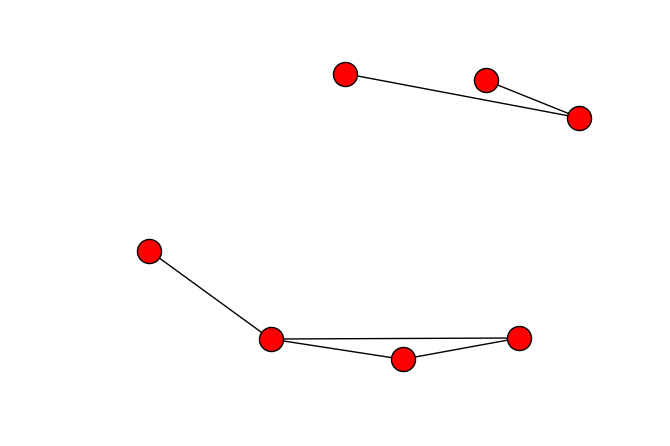

In [9]:
%matplotlib inline

# generating a two component graph
EG = nx.Graph()
EG.add_nodes_from([1, 2, 3, 4, 5, 6, 7])
EG.add_edges_from([(1, 2), (2, 3), (1, 3), (1, 7), (4, 5), (5, 6)])

# draw it
nx.draw_spring(EG)

Considering that each node is an user and the edges represent relations between users, the example graph contains 2 communities which have no connection one to another: (1, 2, 3, 7) and (4, 5, 6).
Let us see if the real-life Twitter social graph is connected or if it contains multiple unlinked communities:

In [10]:
if nx.is_connected(G):
    print "The graph is connected, it has only one connected component"
else:
    print "The graph contains %d connected components." % nx.number_connected_components(G)

The graph contains 344 connected components.


Real social graphs have the tendency of presenting a "giant connected component" which contains most of the users in the network. In other words, most of the users are not isolated. We detect the connected components, sort them by their size and print the size of the first 5 of them, as well as the percentage they represent from the total population.

In [11]:
Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
print "Connected components, inversely sorted by size:"
for i in range(5):
    print "Rank {:d}: {:d} users ({:.3f}% of total population)".format(i, len(Gcc[i]), (float(len(Gcc[i])) * 100 / len(G)))

Connected components, inversely sorted by size:
Rank 0: 3185 users (77.063% of total population)
Rank 1: 91 users (2.202% of total population)
Rank 2: 36 users (0.871% of total population)
Rank 3: 13 users (0.315% of total population)
Rank 4: 10 users (0.242% of total population)


In conclusion, more than 77% of the user population is connected into *one giant connected component*. The remainder of 343 connected components represent less than 23% of the user populations.

**(1 point) Assignment question #2.3:** Using the `networkx` functions, filter the social graph to its *giant connected component*. 
Calculate for this new graph: i) the number of nodes, ii) the number of edges, iii) the radius and iv) the diameter.  
**HINT:** You can either construct a new graph which contains only the nodes and edges in the *giant connected component* or you can remove from your initial graph all the nodes and edges belonging to the other connected components.

 2.3 Page Rank
 ---

In this third part of the tutorial, we compute the PageRank of each node of our social graph. 
PageRank is a link analysis algorithm and it assigns a numerical weighting to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of "measuring" its relative importance within the set. 
The algorithm may be applied to any collection of entities with reciprocal quotations and references, meaning it can be applied on our Twitter user population.
The numerical weight that it assigns to any given element E is referred to as the PageRank of $p$ and denoted by $PR(p)$. 

The "improved" formula for the PageRank is (please see lecture notes):  
$$PR(p) = \frac{(1-d)}{n} + d \sum_{b \in B(p)} \frac{1}{N(b)} PR(b)$$  
where:
* $p$ is the user for which the PageRank is computed;
* $d \in [0, 1]$ is the *decay factor* to avoid sinks and hogs;
* $N(b)$ is the number of outgoing links from page $b$;
* $B(p)$ is the set of back-links towards page $p$ (the set of nodes $b$ so that there is an edge $ b \longrightarrow p$);
* $n$ is the total number of nodes in the graph.

One of the simplest ways to calculate the PageRank iteratively. The PageRank of all nodes are initialized with an equal value:
$$ PageRank^{(0)}(p) = \frac{1}{n}, \forall p \enspace.$$
At each step $k$, the $PageRank^{(k)}(p)$ is calculated depending on the values at the previous step.

The algorithm for calculating the PageRank would be resumed at:  
Initialize $ PageRank^{(0)}(p) = \frac{1}{n}, \forall p$  
repeat  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $ k = k + 1$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; foreach $p$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; determine $N(p)$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; determine $B(p)$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $PR^{(k)}(p) = \frac{(1-d)}{n} + d \sum_{b \in B(p)} \frac{1}{N(b)} PR^{(k-1)}(b)$   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; endforeach  
until $ \left(k > maxiter \right) $

**(1 point) Assignment question #2.4:** This assignment question is to calculate iteratively the basic form of the PageRank on the reply social graph constructed previously. Considering that *DG* is the constructed directed networkx graph constructed at the **Assignment questions #2.1**. We will construct the *PageRank* on the largest [*weakly connected component*](http://en.wikipedia.org/wiki/Connectivity_%28graph_theory%29). This is constructed as shown hereafter.
Your job is to compute the PageRank, using the algorithm provided in the tutorial and exemplified in the lecture notes.
Use a maximum of $maxiter = 20$ iterations.

In [15]:
import operator
from itertools import islice

# get the list of weakly connected components, sorted by size
omp_List = sorted(nx.weakly_connected_component_subgraphs(DG), key = len, reverse=True)

# we want the first component, the biggest
WCDG = omp_List[0]

In [14]:
# get the number of nodes of the graph
n = len(WCDG.nodes())

# initialize the PR at moment 0 using a dictionary of pairs {node : score}
PR = {}
for node in WCDG.nodes():
    PR[node] = 1.0/n

# initialize variables
no_iter=0     # current iteration
iter_max=20   # maximum number of iterations
d = 0.7       # decay factor
while no_iter < iter_max: # iterate until maximum iterations
    
    # at each iteration, we compute a new version of the PageRank for each node
    new_PR = {}
    no_iter = no_iter + 1
    
    # calculate the PageRank of each node (`new_PR[node]`), based on the previous values (`PR[other_nodes]`)
    for node in WCDG.nodes():
        ## code for calculating new_PR[node].
        
    # at the end of iteration, replace old values of PR with the new ones
    PR = new_PR
    
# even if a dictionary is not sorted (it is just a collection) we sort it so that the next
# printing at the screen shows some interesting values
sorted_PR = sorted(PR.iteritems(), key=operator.itemgetter(1), reverse=True)

# and print it out the first 10 elements
dict(islice(sorted_PR, 10))

IndentationError: expected an indented block (<ipython-input-14-4b6c8ac5f8c4>, line 33)

`networkx` already contains methods for computing the PageRank:

In [17]:
from itertools import islice

# compute the pagerank
pr = nx.pagerank(WCDG)

# even if a dictionary is not sorted (it is just a collection) we sort it so that the next
# printing at the screen to show some interesting values
sorted_pr = sorted(pr.iteritems(), key=operator.itemgetter(1), reverse=True)

# and print it out the first 10 elements
dict(islice(sorted_pr, 10))

{16679529: 0.012196708395375032,
 34507480: 0.309677573682929,
 70054190: 0.003492735759827362,
 170656421: 0.009775042845883429,
 393488321: 0.009427027882667242,
 851254111: 0.003445393631551921,
 1123082485: 0.004269944694225775,
 1703320855: 0.0030277533169585464,
 2160213779: 0.0028882460152326833,
 2362948705: 0.004611077925771978}

Optional assignments
---
The purpose of the optional assignments here after is to guide you into a more in depth analysis of the social network.
These assignments are optional and **they will not be graded**.
Whatsoever, if you have questions regarding them, you may discuss them with your tutor or post them on the forum.

**Optional Assignment question:** Compute and compare the first 10 nodes with the highest PageRank according to (i) your results obtained at **Assignment question #2.4** and (ii) the scores computed by the PageRank function integrated into `networkx`.